# Instalasi dan Import Package

In [1]:
!pip install transformers

!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 9.5 MB/s 
     |████████████████████████████████| 596 kB 63.4 MB/s 
     |████████████████████████████████| 6.6 MB 58.0 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 133 kB 7.3 MB/s 


In [2]:
# Import modul yang akan dipakai
import re
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

from transformers import AutoTokenizer, TFAutoModel
from keras_tuner.tuners import BayesianOptimization
import IPython

# Data Pra-processing

In [3]:
# Pendefinisian program untuk membersihkan data
## Import kamus untuk mengubah singkatan
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')

## Membuat dictionary untuk memetakan singkatan dari kata
nor_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in nor_dict:
        nor_dict[row[0]] = row[1]

In [4]:
## Pembersihan data
def clean_text(tweet):
    # Mengubah semua huruf menjadi huruf kecil
    tweet = tweet.lower()
    # Menghapus www.* atau https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Menghapus @username
    tweet = re.sub('@[^\s]+','',tweet)
    # Menghapus tanda #
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    # Menghapus tanda baca
    tweet = re.sub(r'[^\w\s]',' ', tweet)
    # Menghapus angka
    tweet = re.sub(r'[\d-]', '', tweet)
    # Menghapus spasi berlebih
    tweet = re.sub('[\s]+', ' ', tweet)
    # Menghapus tanda \, ', dan "
    tweet = tweet.strip('\'"')
    
    # Pembersihan kata
    words = tweet.split()
    tokens=[]
    for ww in words:
        # Memisahkan kata berulang
        for w in re.split(r'[-/\s]\s*', ww):
            # Menghapus huruf berulang yang lebih dari dua kali
            pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
            w = pattern.sub(r"\1\1", w)
            w = w.strip('\'"?,.')
            # Memeriksa apakah suatu kata terbentuk dari minimal dua huruf
            val = re.search(r"^[a-zA-Z][a-zA-Z][a-zA-Z]*$", w)
            if w in nor_dict:
                w = nor_dict[w]

            if w == "rt" or val is None:
                continue
            else:
                tokens.append(w.lower())
    
    tweet = " ".join(tokens)  
    return tweet

# Lazada

## Read Dataset

In [46]:
LAZADA_PATH = 'Lazada.xlsx'
# Graph Execution Error. Only use around 5200 observations out of around 6200
lazada = pd.read_excel(LAZADA_PATH)[:-1000]
lazada['review'] = lazada['review'].map(lambda x: clean_text(x))
lazada = lazada[lazada['review'].apply(lambda x: len(x.split()) >=1)]

## Drop unlabelled data if exists
lazada = lazada[
                    (lazada['senang'] != 0) |
                    (lazada['antusias'] != 0) |
                    (lazada['penasaran'] != 0) |
                    (lazada['apatis'] != 0) |
                    (lazada['kecewa'] != 0) |
                    (lazada['kesal'] != 0)
]

## Retrieve X data
lazada_data = lazada['review']
lazada_label = lazada.drop(['review'], axis=1)

## Show Example

In [47]:
print(lazada_data.shape)
print(lazada_label.shape)
print()
print(lazada_data[20])
print(np.array(lazada_label)[20])

(5280,)
(5280, 6)

saya pengguna baru sih baru bulan orderan lumayan banyak karena aku onlineshop juga belum pernah mengecewakan selama berbelanja lazada barang realpict jadi ke konsumen nya juga senang dan mereka repeat order lagi tips biar barang selalu bikin puas realpict sesuai gambar harus pintar cari seller yang baik fast respon dan banyak konsumen yang kasih bintang itu tandanya seller amanah dan barang yang jual juga kualitasnya bagus sukses buat lazada
[1. 0. 0. 0. 0. 0.]


## Plot Sentiment Distribution

senang: 1205
antusias: 499
penasaran: 562
apatis: 502
kecewa: 1645
kesal: 867


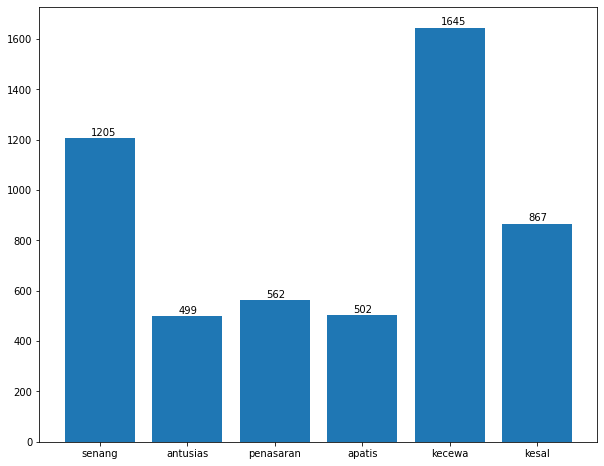

In [48]:
counts = []
lazada_labels = []
for col in lazada_label.columns:
  lazada_labels.append(col)
  counts.append(lazada_label[lazada_label[col] == 1][col].count())
  print(f'{col}:', lazada_label[lazada_label[col] == 1][col].count())

plt.figure(figsize=(10, 8))
plt.bar(lazada_labels, counts)

xlocs, xlabs = plt.xticks()
for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.1, v + 10, str(v))

# Shopee

## Read Dataset

In [49]:
SHOPEE_PATH = 'Shopee.xlsx'
shopee = pd.read_excel(SHOPEE_PATH)

shopee['review'] = shopee['review'].map(lambda x: clean_text(x))
shopee = shopee[shopee['review'].apply(lambda x: len(x.split()) >=1)]

## Drop unlabelled data if exists
shopee = shopee[
                    (shopee['senang'] != 0) |
                    (shopee['antusias'] != 0) |
                    (shopee['penasaran'] != 0) |
                    (shopee['apatis'] != 0) |
                    (shopee['kecewa'] != 0) |
                    (shopee['kesal'] != 0)
]

## Retrieve X data
shopee_data = shopee['review']
shopee_label = shopee.drop(['review'], axis=1)

## Show Example

In [50]:
print(shopee_data.shape)
print(shopee_label.shape)
print()
print(shopee_data[20])
print(np.array(shopee_label)[20])

(4991,)
(4991, 6)

saya sudah di tipu oleh shopee dengan belanja cash di alfamart pada tanggal maret dengan pengiriman jasa jne tapi sampai saat ini barang tidak di kirim kan penipuan somoga ini jadi pelajaran bagi orang lain tolong tanggapi pihak shopee jangan makan uang haram
[0. 0. 0. 0. 0. 1.]


## Plot Sentiment Distribution

senang: 1610
antusias: 463
penasaran: 570
apatis: 74
kecewa: 773
kesal: 1502


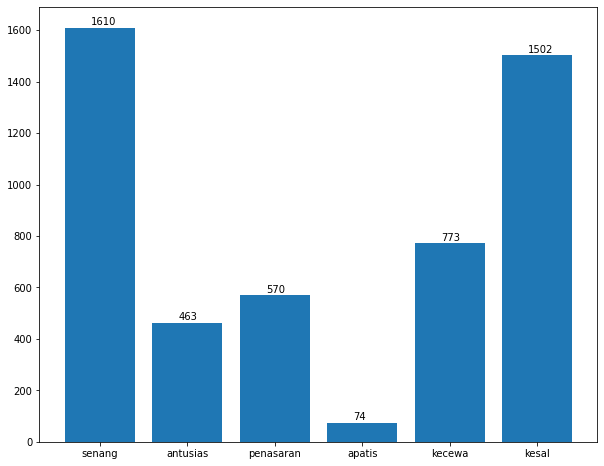

In [51]:
counts = []
shopee_labels = []
for col in shopee_label.columns:
  shopee_labels.append(col)
  counts.append(shopee_label[shopee_label[col] == 1][col].count())
  print(f'{col}:', shopee_label[shopee_label[col] == 1][col].count())

plt.figure(figsize=(10, 8))
plt.bar(shopee_labels, counts)

xlocs, xlabs = plt.xticks()
for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.1, v + 10, str(v))

# Tokopedia

## Read Dataset

In [52]:
TOKOPEDIA_PATH = 'Tokopedia.xlsx'
tokopedia = pd.read_excel(TOKOPEDIA_PATH)

tokopedia['review'] = tokopedia['review'].map(lambda x: clean_text(x))
tokopedia = tokopedia[tokopedia['review'].apply(lambda x: len(x.split()) >=1)]

## Drop unlabelled data if exists
tokopedia = tokopedia[
                    (tokopedia['senang'] != 0) |
                    (tokopedia['antusias'] != 0) |
                    (tokopedia['penasaran'] != 0) |
                    (tokopedia['apatis'] != 0) |
                    (tokopedia['kecewa'] != 0) |
                    (tokopedia['kesal'] != 0)
]

## Retrieve X data
tokopedia_data = tokopedia['review']
tokopedia_label = tokopedia.drop(['review'], axis=1)

## Show Example

In [53]:
print(tokopedia_data.shape)
print(tokopedia_label.shape)
print()
print(tokopedia_data[20])
print(np.array(tokopedia_label)[20])

(4360,)
(4360, 6)

ini bagaimana saya lagi transaksi gede kok app nya error kendala koneksi barang nya saya enggak tau sudah sampai mana di proses atau belum aduh masih mending kalo transaksi nya cuma ratusan rebu ini jutaan om di kirim pakai gosend pula bagaimana nih
[0. 0. 0. 0. 0. 1.]


## Plot Sentiment Distribution

senang: 910
antusias: 200
penasaran: 898
apatis: 671
kecewa: 1280
kesal: 401


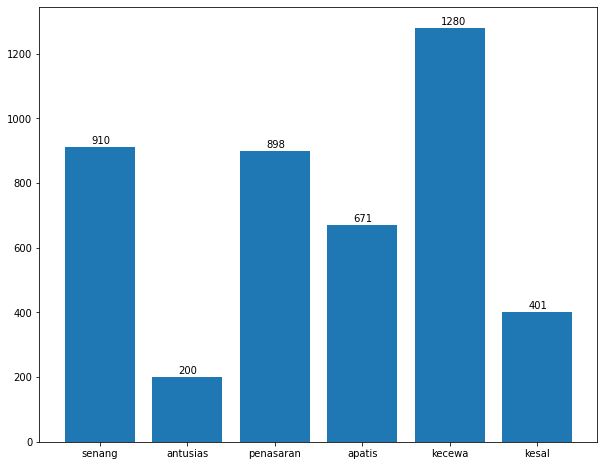

In [54]:
counts = []
tokopedia_labels = []
for col in tokopedia_label.columns:
  tokopedia_labels.append(col)
  counts.append(tokopedia_label[tokopedia_label[col] == 1][col].count())
  print(f'{col}:', tokopedia_label[tokopedia_label[col] == 1][col].count())

plt.figure(figsize=(10, 8))
plt.bar(tokopedia_labels, counts)

xlocs, xlabs = plt.xticks()
for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.1, v + 10, str(v))

# BERT Initialization

## Installation

In [16]:
# Memnggil model dan tokenizer IndoBERT
bert_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2", trainable=False)
bert_tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Tokenization

In [17]:
# Pendefinisian fungsi untuk melakukan tokenisasi pada satu data
def tokenisasi(teks):
      encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128, #maximum token per kalimat = 125
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

      tokenID = encode_dict['input_ids']
      attention_mask = encode_dict['attention_mask']

      return tokenID, attention_mask

In [18]:
# Pendefinisian fungsi untuk mengambil hasil tokenisasi pada semua data
def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)
    
    return [np.asarray(tokenID, dtype=np.int32).reshape(-1, 128), 
            np.asarray(input_mask, dtype=np.int32).reshape(-1, 128)]

# Train-Test Split

In [36]:
# Pick one
data_train, data_test, label_train, label_test = train_test_split(lazada_data, lazada_label, test_size=0.2, random_state=7)
# data_train, data_test, label_train, label_test = train_test_split(shopee_data, shopee_label, test_size=0.2, random_state=7)
# data_train, data_test, label_train, label_test = train_test_split(tokopedia_data, tokopedia_label, test_size=0.2, random_state=7)

In [37]:
# Creating token ID and Mask for input
X_train = create_input(data_train)
X_test = create_input(data_test)

print(X_train[0].shape, X_train[1].shape, label_train.shape)
print(X_test[0].shape, X_test[1].shape, label_test.shape)

(4224, 128) (4224, 128) (4224, 6)
(1056, 128) (1056, 128) (1056, 6)


# Model Initialization

## F1-Score Metrics Initialization

In [38]:
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

def get_f1(y_true, y_pred): # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Model

In [39]:
def model(hp):
    #Input layer
    input_token = keras.layers.Input(shape=(128,), dtype=np.int32,
                                        name="input_token")
    input_mask = keras.layers.Input(shape=(128,), dtype=np.int32,
                                   name="input_mask")
    
    # Embedding
    bert_embedding = bert_model([input_token, input_mask])[0]  

    # LSTM layer
    lstm = keras.layers.LSTM(units = hp.Int('units',
                                             min_value = 100,
                                             max_value = 200,
                                             step = 50),
                             kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                 values = [0.01, 0.001])),
                             recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                    values = [0.01, 0.001])),
                             return_sequences=True)(bert_embedding)

    # Convolution layer
    cnn = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 200, 
                                                max_value = 300, 
                                                step = 50),
                              kernel_size = hp.Int('kernel_size',
                                                min_value = 3, 
                                                max_value = 5, 
                                                step = 1),
                              activation='relu',
                              kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                    values = [0.01, 0.001])))(lstm)
                                                                                    
    # Max Pooling layer
    maxpool = keras.layers.GlobalMaxPooling1D()(cnn)

    # Output layer
    output = keras.layers.Dense(6, activation='softmax',
                                kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.01, 0.001])))(maxpool)
    model = keras.models.Model(inputs=[input_token, input_mask], outputs=output)

    model.compile(optimizer = keras.optimizers.Adam(1e-3),
                  loss ='categorical_crossentropy',
                  metrics=['accuracy',
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            get_f1])
    
    return model

### Hyperparameter Tuning

In [40]:
#Hyperparameter tuning
tuner = BayesianOptimization(model,
                             objective = 'val_accuracy', 
                             max_trials = 10,
                             directory = '/content/results',
                             project_name = 'Sentiment-Analysis-with-BERT-LSTM-CNN',
                             overwrite = True)

### Callback Initialization

In [41]:
# Pendefinisian Callback
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Tuner Search

In [ ]:
tuner.search(X_train, label_train,
             batch_size=32, epochs=50,
             validation_data=(X_test, label_test),
             callbacks=[early_stop, ClearTrainingOutput()])

### Model Terbaik

In [ ]:
# Mendapatkan model terbaik
model = tuner.get_best_models()[0]

### Evaluasi Model

In [ ]:
# Mendapatkan kinerja model
y_pred = np.argmax(model.predict(X_test), axis=1)
y = np.argmax(np.array(label_test), axis=1)
print('accuracy: ', accuracy_score(y, y_pred), 
      '\nprecision: ', precision_score(y, y_pred, average=None), 
      '\nrecall: ', recall_score(y, y_pred, average=None),
      '\nf1-score: ', f1_score(y, y_pred, average=None))

In [ ]:
labels = ['senang', 'antusias', 'penasaran', 'apatis', 'kecewa', 'kesal']
print(classification_report(y, y_pred, target_names=labels))